Group A: Use the FMETF Column

1st: LSTM
2nd: ARIMA
3rd: ARIMA-GARCH

LSTM Testing:

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [5]:
def lstm_predict(column_name, time_step=20, epochs=20, batch_size=32):
    """
    column_name (str): The name of the column to forecast
    time_step (int): The number of past time steps to use for prediction
    epochs (int): The number of training epochs
    batch_size (int): The batch size for training
    
    returns an lstm model
    """

    stock_data = pd.read_excel("stock_data.xlsx")
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(stock_data[column_name].to_numpy().reshape(-1, 1))
    
    def create_dataset(data, time_step):
        X, y = [], []
        for i in range(len(data) - time_step - 1):
            X.append(data[i: (i + time_step), 0])
            y.append(data[i + time_step, 0])
        return np.array(X), np.array(y)
    
    X, y = create_dataset(data_scaled, time_step)
    
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    train_predict = scaler.inverse_transform(train_predict)
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    test_predict = scaler.inverse_transform(test_predict)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    train_score = mean_squared_error(y_train[:, 0], train_predict[:, 0])
    test_score = mean_squared_error(y_test[:, 0], test_predict[:, 0])
    
    print(f"Train MSE: {train_score: .4f}")
    print(f"Test MSE: {test_score: .4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(data_scaled), label=f"{column_name} (Original)")
    
    train_plot = np.empty_like(data_scaled)
    train_plot[:, :] = np.nan
    train_plot[time_step:len(train_predict) + time_step, :] = train_predict
    plt.plot(train_plot, label="In-Sample Prediction")
    
    test_plot = np.empty_like(data_scaled)
    test_plot[:, :] = np.nan
    test_plot[len(train_predict) + 1:len(train_predict) + len(test_predict) + 1, :] = test_predict
    plt.plot(test_plot, label="Out-Sample Prediction")
    
    plt.legend()
    plt.title(f"LSTM Prediction for {column_name}")
    plt.show()
    
    return model

In [6]:
# Testing by using default values:
# lstm_predict(column_name="FMETF")

# Train MSE:  6.0406
# Test MSE:  4.3550

In [8]:
# Testing by having more time steps (remember more from the past):
# lstm_predict(column_name="FMETF", time_step=30)

# Train MSE:  6.6098
# Test MSE:  5.2014

In [10]:
# Testing by having more epochs (more steps before stopping):
# lstm_predict(column_name="FMETF", epochs=30)

# Train MSE:  4.5113
# Test MSE:  3.2348

In [12]:
# Testing by increasing batch size (bigger bites to digest for the model):
# lstm_predict(column_name="FMETF", batch_size=64)

# Train MSE:  8.2588
# Test MSE:  6.5057

In [14]:
# Testing by increasing everything:
# lstm_predict(column_name="FMETF", time_step=30, epochs=30, batch_size=64)

# Train MSE:  6.2202
# Test MSE:  4.7046

Now by editing the old model:

In [23]:
def custom_lstm_predict(column_name, time_step=20, epochs=20, batch_size=32, learning_rate=0.002):
    """
    column_name (str): The name of the column to forecast
    time_step (int): The number of past time steps to use for prediction
    epochs (int): The number of training epochs
    batch_size (int): The batch size for training
    learning_rate: adjusts the learning rate for the optimizer
    
    returns an lstm model
    """

    stock_data = pd.read_excel("stock_data.xlsx")
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(stock_data[column_name].to_numpy().reshape(-1, 1))
    
    def create_dataset(data, time_step):
        X, y = [], []
        for i in range(len(data) - time_step - 1):
            X.append(data[i: (i + time_step), 0])
            y.append(data[i + time_step, 0])
        return np.array(X), np.array(y)
    
    X, y = create_dataset(data_scaled, time_step)
    
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Given more units, random dropouts while training
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    train_predict = scaler.inverse_transform(train_predict)
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    test_predict = scaler.inverse_transform(test_predict)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    train_score = mean_squared_error(y_train[:, 0], train_predict[:, 0])
    test_score = mean_squared_error(y_test[:, 0], test_predict[:, 0])
    
    print(f"Train MSE: {train_score: .4f}")
    print(f"Test MSE: {test_score: .4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(data_scaled), label=f"{column_name} (Original)")
    
    train_plot = np.empty_like(data_scaled)
    train_plot[:, :] = np.nan
    train_plot[time_step:len(train_predict) + time_step, :] = train_predict
    plt.plot(train_plot, label="In-Sample Prediction")
    
    test_plot = np.empty_like(data_scaled)
    test_plot[:, :] = np.nan
    test_plot[len(train_predict) + 1:len(train_predict) + len(test_predict) + 1, :] = test_predict
    plt.plot(test_plot, label="Out-Sample Prediction")
    
    plt.legend()
    plt.title(f"LSTM Prediction for {column_name}")
    plt.show()
    
    return model

Epoch 1/20
24/24 [==============================] - 3s 35ms/step - loss: 0.0499 - val_loss: 0.0029
Epoch 2/20
24/24 [==============================] - 0s 16ms/step - loss: 0.0087 - val_loss: 0.0028
Epoch 3/20
24/24 [==============================] - 0s 16ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 4/20
24/24 [==============================] - 0s 15ms/step - loss: 0.0059 - val_loss: 0.0025
Epoch 5/20
24/24 [==============================] - 0s 16ms/step - loss: 0.0055 - val_loss: 0.0022
Epoch 6/20
24/24 [==============================] - 0s 16ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 7/20
24/24 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 8/20
24/24 [==============================] - 0s 15ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 9/20
24/24 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 10/20
24/24 [==============================] - 0s 16ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 11/

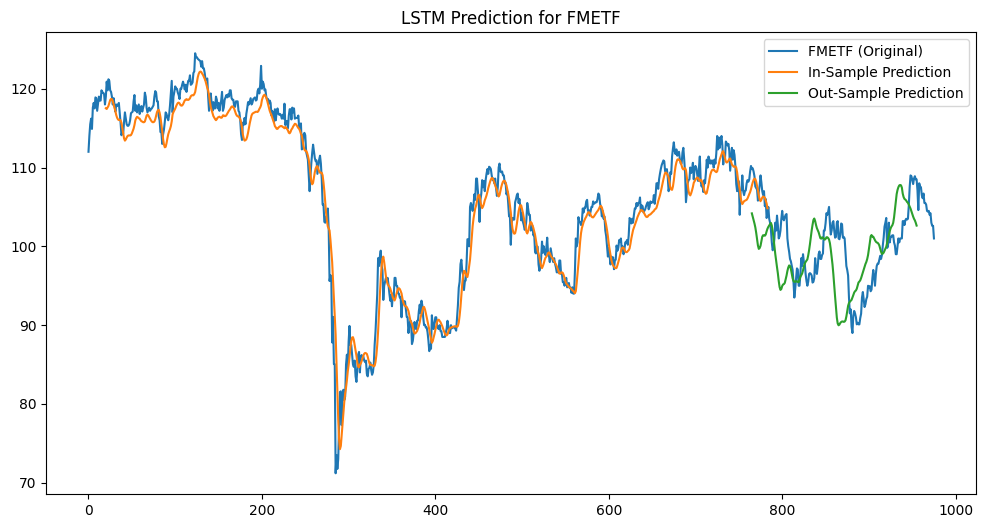

In [24]:
# Default values using custom LSTM model:
# custom_lstm_predict(column_name="FMETF")

# Train MSE:  5.3266
# Test MSE:  3.4094

In [ ]:
# To Do:
# 1. Replicate the "default" model using ARIMA
# 2. Replicate the "default" model using ARIMA-GARCH
# 3. Set the random seed to have reproducibility
# 4. Maybe set custom function for the graphs
# 5. Convert to Class for callable graphs/functions/model